# Investigating speedrunning world records in python

Speedrunners are video game players who compete with each other to complete games as quickly as possible. The most dedicated are willing to practice almost 24/7 in order to improve world records by even the slimmest of margins. 

A unique dynamic of speedrunning records, which sets them apart from those of similar domains such as physical speed sports, is the importance of innovation. The discovery of glitches or optimizations can transform the landscape of a speedrunning record overnight, cutting records in half or more. The same behavior is simply inconceivable in physical speed sports- there is zero chance that world record for the mile is going to drop from four minutes to two tomorrow. 

This makes the speedrunning world a fertile ground for exploring the dynamics of innovation. We can explore many questions, such as
- Does innovation beget more innovation?
- To what degree can innovation be predicted, and to what degree is it irretrivably chaotic? 

## 1. Setting up 

We will use data from speedrun.com, which conveniently can be obtained via API. The python wrapper for the APi is called 'srcomapi'

In [1444]:
import srcomapi, srcomapi.datatypes as dtp
import pandas as pd
import plotly.express as px
import numpy as np
import statsmodels as sm
import statsmodels.api as smapi
from statsmodels.api import OLS
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import warnings
import scipy.stats as st
import plotly.graph_objects as go
from scipy.optimize import curve_fit
import time
import matplotlib.pyplot as plt
import re
from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter,LogNormalFitter,LogLogisticFitter,ExponentialFitter,CoxPHFitter
from lifelines.plotting import qq_plot
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import plot_roc_curve, RocCurveDisplay, roc_auc_score

Speedrun.com has 'runs' for thousands of games and sub-categories. Unfortunately we cannot easily extract data for every game and sub-category, because the speedrun.com API only allows us to make 100 requests per minute. 

We will start with the 15 games with the most runs, as listed here: https://www.speedrun.com/games#platform=&orderby=mostruns&unofficial=off

Later we can pull the second batch of 13

In [1445]:
api = srcomapi.SpeedrunCom(); api.debug = 1
games = [api.search(srcomapi.datatypes.Game, {"name": "super mario 64"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "minecraft: java"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "super mario odyssey"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "celeste"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "mario kart 8"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "portal"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "super metroid"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "mario sunshine"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "super mario world"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "getting over it with bennett foddy"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "roblox: speed run 4"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "ocarina of time"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "seterra"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "super mario bros"})[0]
         ,api.search(srcomapi.datatypes.Game, {"name": "a link to the past"})[0]

        ]

games

https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games


[<Game "Super Mario 64">,
 <Game "Minecraft: Java Edition">,
 <Game "Super Mario Odyssey">,
 <Game "Celeste">,
 <Game "Mario Kart 8">,
 <Game "Portal">,
 <Game "Super Metroid">,
 <Game "Super Mario Sunshine">,
 <Game "Super Mario World">,
 <Game "Getting Over It With Bennett Foddy">,
 <Game "ROBLOX: Speed Run 4">,
 <Game "SM64: Ocarina of Time">,
 <Game "Seterra">,
 <Game "Super Mario Bros.">,
 <Game "The Legend of Zelda: A Link to the Past">]

In [1446]:
games_additional = [api.search(srcomapi.datatypes.Game, {"name": "battle for bikini bottom"})[0]
                     ,api.search(srcomapi.datatypes.Game, {"name": "resident evil 2"})[0]
                     ,api.search(srcomapi.datatypes.Game, {"name": "minecraft: bedrock"})[0]
                     ,api.search(srcomapi.datatypes.Game, {"name": "refunct"})[0]
                     ,api.search(srcomapi.datatypes.Game, {"name": "undertale"})[0]
                     ,api.search(srcomapi.datatypes.Game, {"name": "wii sports resort"})[0]
                     ,api.search(srcomapi.datatypes.Game, {"name": "outlast"})[0]
                     ,api.search(srcomapi.datatypes.Game, {"name": "breath of the wild"})[0]
                     ,api.search(srcomapi.datatypes.Game, {"name": "there is no game"})[0]
                     ,api.search(srcomapi.datatypes.Game, {"name": "hades"})[0]
                     ,api.search(srcomapi.datatypes.Game, {"name": "roblox: piggy"})[0]
                     ,api.search(srcomapi.datatypes.Game, {"name": "hollow knight"})[0]
                     ,api.search(srcomapi.datatypes.Game, {"name": "portal 2"})[0]
                   ]

games_additional    

https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games


[<Game "Battle for Bikini Bottom: Second Strike">,
 <Game "Resident Evil 2">,
 <Game "Minecraft: Bedrock Edition">,
 <Game "Refunct">,
 <Game "Undertale">,
 <Game "Wii Sports Resort">,
 <Game "Outlast">,
 <Game "The Legend of Zelda: Breath of the Wild">,
 <Game "There Is No Game">,
 <Game "Hades">,
 <Game "ROBLOX: Piggy">,
 <Game "Hollow Knight">,
 <Game "Portal 2">]

The API will return data as jsons. For our analysis, a dataframe will be more convenient, so we will convert the API results to dataframe as we process them

In [1447]:
#future improvement: get names of runners. Right now, accessing the name forces an API call every time, which is 
#bad for performance

#below code based on https://github.com/blha303/srcomapi accessed on 2021-07-04
def add_games(full_df
              ,games):
    '''Adds game data from speedrun.com api to dataframe
    
    Args:
        full_df (df): Dataframe, either empty or with some game data
        games (list): list of game objects

    Returns:
        full_df with rows from additional games
    '''
    
    for game in games: 
        game_df = pd.DataFrame()
        try:
            for category in game.categories:
                if category.type == 'per-level':
                    #for level categories, we need an extra internal loop
                    for level in game.levels:
                        leaderboard = dtp.Leaderboard(
                             api
                             ,data=api.get("leaderboards/{}/level/{}/{}?embed=variables".format(game.id, level.id, category.id))
                                                     )
                        tuples = [get_tuple(run) for run in leaderboard.runs]
                        df = pd.DataFrame(tuples, columns = ['DATE','TIME'])

                        name = category.name + '_' + level.name
                        try: 
                            df.loc[:,'CATEGORY'] = name
                            sms_df = pd.concat([game_df, df])
                        except:
                            pass
                else:
                    #for other categories, we can grab the leaderboard with one API call
                    leaderboard = dtp.Leaderboard(
                        api
                        ,data=api.get("leaderboards/{}/category/{}?embed=variables".format(game.id, category.id))
                                                 )
                    tuples = [get_tuple(run) for run in leaderboard.runs]
                    df = pd.DataFrame(tuples, columns = ['DATE','TIME'])
                    df.loc[:,'CATEGORY'] = category.name
                    game_df = pd.concat([game_df, df])
            game_df.loc[:,'GAME'] = game.name
            full_df = pd.concat([full_df, game_df])
        except:
            continue
    return full_df


def get_tuple(run):
    '''Extracts date and time (aka score) from run object with error handling
    This is necessary because list comprehensions cannot handle error handling themselves
    
    Args:
       run  (run object)

    Returns:
        List of bills    
    '''
    
    try: date = run['run'].date
    except: date = None
        
    try: time = run['run'].times['primary_t']
    except: time = None
        
    return (date,time)

full_df = pd.DataFrame()
full_df = add_games(full_df, games)
full_df.head()

https://www.speedrun.com/api/v1/games/o1y9wo6q/categories
https://www.speedrun.com/api/v1/games/o1y9wo6q/levels
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/r9gzzkjd/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/o9x22m3w/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/495jjvmw/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/rdq006ow/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/5d7776qd/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/kwjyyo0w/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/owokkgjd/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/xd100vz9/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/ewpppkyw/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboar

https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/category/zd365jyd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/category/zd36mqyd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/category/xd1ex5r2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/level/ywe5zq7w/wk67rved?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/level/69z2m8g9/wk67rved?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/level/r9g4k7p9/wk67rved?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/level/o9x7mxpd/wk67rved?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/level/4955vm39/wk67rved?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/level/rdq76n29/wk67rved?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/level/5d746x6d/wk67rved?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/level/kwjzo679/wk67rved?

https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/kn9372d0/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/oz986rdl/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/krdn05wm/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/zldyypd3/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/kn9377d0/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/oz9867dl/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/xd0kl849/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/rw6qrzgd/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/n93q8rzw/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/z98rexpd/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/

https://www.speedrun.com/api/v1/games/pd0wx9w1/levels
https://www.speedrun.com/api/v1/leaderboards/pd0wx9w1/level/rw6e3kpd/w20g71jk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0wx9w1/level/yweml2qd/w20g71jk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0wx9w1/level/69znzp69/w20g71jk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0wx9w1/level/r9g1xyq9/w20g71jk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0wx9w1/level/o9x34169/w20g71jk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0wx9w1/level/495l4k2d/w20g71jk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0wx9w1/level/rdq5lzmd/w20g71jk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0wx9w1/level/5d7z8y5w/w20g71jk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0wx9w1/level/kwj1p7rw/w20g71jk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0wx9w1/level/owoqy7vd/w20g71jk?embed=variables
https:

https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/ywe5o57w/9d84e46k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/69z212g9/9d84e46k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/r9g4p4p9/9d84e46k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/o9x7j7pd/9d84e46k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/4955e539/9d84e46k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/rdq7e729/9d84e46k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/5d74g86d/9d84e46k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/kwjz2p79/9d84e46k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/owo6rykw/9d84e46k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/xd12nx5w/9d84e46k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/

https://www.speedrun.com/api/v1/leaderboards/k6q4rqzd/level/rdnrj07w/9kv7gzok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/k6q4rqzd/level/kwj3mxnd/9kv7gzok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/k6q4rqzd/level/69znnz69/9kv7gzok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/k6q4rqzd/level/rdq5ok1d/9kv7gzok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/k6q4rqzd/level/rdq340gw/9kv7gzok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/k6q4rqzd/level/5d7zxmvw/9kv7gzok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/k6q4rqzd/level/y9m1gl19/9kv7gzok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/k6q4rqzd/level/ldyljkr9/9kv7gzok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/k6q4rqzd/level/rdn4rx79/9kv7gzok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/k6q4rqzd/level/n938prnw/9kv7gzok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/k6q4rqzd/level/

https://www.speedrun.com/api/v1/leaderboards/om1m3625/category/wdmz042q?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1m3625/category/xd1em828?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1m3625/category/mke8vjk6?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1m3625/category/5dwv95kg?embed=variables
https://www.speedrun.com/api/v1/games/9d3rr0dl/categories
https://www.speedrun.com/api/v1/leaderboards/9d3rr0dl/category/wk6jz5rd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/9d3rr0dl/category/ndx9y8rd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/9d3rr0dl/category/n2y180m2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/9d3rr0dl/category/jdz8nmvd?embed=variables


,DATE,TIME,CATEGORY,GAME
0,2021-04-09,5901.0,120 Star,Super Mario 64
1,2021-01-29,5905.0,120 Star,Super Mario 64
2,2020-05-29,5908.0,120 Star,Super Mario 64
3,2021-03-04,5912.0,120 Star,Super Mario 64
4,2020-03-31,5923.0,120 Star,Super Mario 64


We can run the below to add more games. Watch out: if you run it directly after the original call, you might get too many API calls and the operation will shut down

In [1448]:
full_df = add_games(full_df, games_additional)

https://www.speedrun.com/api/v1/games/yd4oqqg1/categories
https://www.speedrun.com/api/v1/leaderboards/yd4oqqg1/category/zd3we4yk?embed=variables
https://www.speedrun.com/api/v1/games/m1zjmz60/categories
https://www.speedrun.com/api/v1/games/m1zjmz60/levels
https://www.speedrun.com/api/v1/leaderboards/m1zjmz60/level/o9xln39l/xk986y20?embed=variables
https://www.speedrun.com/api/v1/leaderboards/m1zjmz60/level/o9xln39l/wk6p91qd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/m1zjmz60/level/o9xln39l/n2yqwjzk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/m1zjmz60/level/o9xln39l/7kjvxznk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/m1zjmz60/category/82466qnd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/m1zjmz60/category/jdz88r6d?embed=variables
https://www.speedrun.com/api/v1/leaderboards/m1zjmz60/category/jdrxxwld?embed=variables
https://www.speedrun.com/api/v1/leaderboards/m1zjmz60/category/7kjpplzk?embed=variables
https://www.sp

https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/4955zx29/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/rdq7o4m9/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/5d74xq5d/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/kwjz64r9/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/owo654vw/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/xd12ylqw/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/ewpxo4ld/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/y9mxg4lw/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/5wk6e459/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/592qreg9/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/

https://www.speedrun.com/api/v1/leaderboards/76r43l18/category/7kjpj1zk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76r43l18/category/z2760lod?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76r43l18/category/zdn45xxk?embed=variables
https://www.speedrun.com/api/v1/games/76r43l18/levels
https://www.speedrun.com/api/v1/leaderboards/76r43l18/level/gdrr2ozd/wk60r9ok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76r43l18/level/nwl03zrw/wk60r9ok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76r43l18/level/ywe0l3r9/wk60r9ok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76r43l18/level/69z7z6ow/wk60r9ok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76r43l18/level/r9g6xqkw/wk60r9ok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76r43l18/level/o9x64r19/wk60r9ok?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76r43l18/level/495p4xjw/wk60r9ok?embed=variables
https://www.speedrun.com

https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/xd0g1y0w/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/rw641xn9/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/n9371e7d/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/nwlleq0w/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/ywe1pryd/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/69z30yld/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/r9g28e5d/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/o9xn080w/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/4956n30d/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/z988e219/zd3op4nd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/

https://www.speedrun.com/api/v1/leaderboards/nd2z5qd0/level/5d7vq5gd/n2yjn9m2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/nd2z5qd0/level/69z4jolw/n2yjn9m2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/nd2z5qd0/level/kwj54jn9/n2yjn9m2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/nd2z5qd0/level/5d7vq5gd/vdo8vr9k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/nd2z5qd0/level/69z4jolw/vdo8vr9k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/nd2z5qd0/level/kwj54jn9/vdo8vr9k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/nd2z5qd0/category/n2yo608d?embed=variables
https://www.speedrun.com/api/v1/leaderboards/nd2z5qd0/category/02qp037d?embed=variables
https://www.speedrun.com/api/v1/leaderboards/nd2z5qd0/level/5d7vq5gd/9d8x04w2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/nd2z5qd0/level/69z4jolw/9d8x04w2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/nd2z5qd0/level/kwj54jn9/9d8

## 2.  Exploratory data analysis

Let's transform the data to show what we are most interested in- record-breaking runs. At the same time, we will keep track of interesting metrics to analyze later

In [1469]:
def feature_engineering(df, category_threshold = 50):
    '''Takes raw dataframe of game data and transforms to record-based dataframe with features
    
    Args:
       df (df): Dataframe with game data
       category_threshold (int): number of runs needed to count category

    Returns:
        Dataframe with record data  
    '''
    
    #the df is sorted by time so that if there are multiple records broken on the same day, only the first will count
    #this is the only way to resolve multiple records on the same day, because we don't know how many were real 
    #record breaks without knowing the time they were submitted
    full_df_processed = df.dropna().sort_values(['GAME','CATEGORY','DATE','TIME']).copy()

    #adding features based on all runs, not just records
    full_df_processed.loc[:,'CURRENT_RECORD'] = full_df_processed.groupby(['CATEGORY'])['TIME'].cummin()
    full_df_processed.loc[:,'PREVIOUS_RECORD'] = full_df_processed.groupby(['CATEGORY','GAME'])['CURRENT_RECORD'].shift(1)

    full_df_processed.loc[:,'CUMULATIVE_RUNS'] = full_df_processed.groupby(['GAME','CATEGORY']).cumcount()
    full_df_processed.loc[:,'FUTURE_RUNS'] = full_df_processed.groupby(['GAME','CATEGORY']).cumcount(ascending = False)

    full_df_processed.loc[:,'RECORD_FLAG'] = full_df_processed['TIME'] < full_df_processed['PREVIOUS_RECORD']

    #picking out only records from frequently played categories- smaller ones might have odd behavier
    category_counts  = full_df_processed.groupby(['GAME','CATEGORY'], as_index = False)['TIME'].count()
    large_categories = category_counts.loc[category_counts['TIME'] > category_threshold, ['GAME','CATEGORY']]
    full_df_processed_large_categories = full_df_processed.merge(large_categories)
    records = full_df_processed_large_categories[full_df_processed_large_categories['RECORD_FLAG']].copy()
    
    #number of days that the record stood, or is standing
    records.loc[:,'AFTER_DATE'] = records.groupby(['GAME','CATEGORY'])['DATE'].shift(-1)
    records.loc[:,'IS_STANDING'] = records['AFTER_DATE'] != records['AFTER_DATE']
    records.loc[:,'AFTER_DATE'] = records['AFTER_DATE'].fillna(datetime.datetime.today())
    records.loc[:,'DAYS_STANDING'] = (pd.to_datetime(records['AFTER_DATE']) - pd.to_datetime(records['DATE'])).dt.days
    records.loc[:,'PREVIOUS_DAYS_STANDING'] = records.groupby(['GAME','CATEGORY'])['DAYS_STANDING'].shift(1)

    #percentage improvement against previous record
    records.loc[:,'PREVIOUS_TIME'] = records.groupby(['GAME','CATEGORY'])['TIME'].shift(1)
    records.loc[:,'RATIO_CUT'] = (1 - records['TIME']/records['PREVIOUS_TIME'])

    #number of runs required to reach the record
    records.loc[:,'PREVIOUS_CUMULATIVE_RUNS'] = records.groupby(['GAME','CATEGORY'])['CUMULATIVE_RUNS'].shift(1)
    records.loc[:,'AFTER_CUMULATIVE_RUNS'] = records.groupby(['GAME','CATEGORY'])['CUMULATIVE_RUNS'].shift(-1)
    records.loc[:,'RUNS_SINCE_LAST'] = records['CUMULATIVE_RUNS'] - records['PREVIOUS_CUMULATIVE_RUNS']

    #number of runs for which the record stood, or is standing 
    records.loc[:,'RUNS_STANDING'] = (records['AFTER_CUMULATIVE_RUNS'] - records['CUMULATIVE_RUNS']).fillna(records['FUTURE_RUNS'])
    records.loc[:,'PREVIOUS_RUNS_STANDING'] = records.groupby(['GAME','CATEGORY'])['RUNS_STANDING'].shift(1)

    #get days since first record
    records.loc[:,'DATE_FIRST_RECORD'] = records.groupby(['GAME','CATEGORY'])['DATE'].transform('first')
    records.loc[:,'DAYS_SINCE_FIRST_RECORD'] = (pd.to_datetime(records['DATE']) - pd.to_datetime(records['DATE_FIRST_RECORD'])).dt.days

    return records

records = feature_engineering(full_df)
records.head()

,DATE,TIME,CATEGORY,GAME,CURRENT_RECORD,PREVIOUS_RECORD,CUMULATIVE_RUNS,FUTURE_RUNS,RECORD_FLAG,AFTER_DATE,...,PREVIOUS_DAYS_STANDING,PREVIOUS_TIME,RATIO_CUT,PREVIOUS_CUMULATIVE_RUNS,AFTER_CUMULATIVE_RUNS,RUNS_SINCE_LAST,RUNS_STANDING,PREVIOUS_RUNS_STANDING,DATE_FIRST_RECORD,DAYS_SINCE_FIRST_RECORD
2,2019-09-24,8896.763,100%,Celeste,8896.763,9536.898,2,62,True,2019-12-18,...,NaN,NaN,NaN,NaN,6.0,NaN,4.0,NaN,2019-09-24,0
6,2019-12-18,6660.481,100%,Celeste,6660.481,8896.763,6,58,True,2020-03-15,...,85.0,8896.763,0.251359,2.0,10.0,4.0,4.0,4.0,2019-09-24,85
10,2020-03-15,6494.170,100%,Celeste,6494.170,6660.481,10,54,True,2020-03-20,...,88.0,6660.481,0.024970,6.0,11.0,4.0,1.0,4.0,2019-09-24,173
11,2020-03-20,6491.195,100%,Celeste,6491.195,6494.170,11,53,True,2020-08-07,...,5.0,6494.170,0.000458,10.0,30.0,1.0,19.0,1.0,2019-09-24,178
30,2020-08-07,6176.780,100%,Celeste,6176.780,6491.195,30,34,True,2021-07-05 09:59:00.282642,...,140.0,6491.195,0.048437,11.0,NaN,19.0,34.0,19.0,2019-09-24,318


We filtered for categories with a sizeable number of runs, defined for now as 50 or more. So with that constraint, what games/categories remain?

In [1470]:
series = records[['GAME','CATEGORY']].drop_duplicates().sort_values('GAME').reset_index().drop(columns = 'index')
print(series)

                  GAME            CATEGORY
0              Celeste                100%
1              Celeste         All A-Sides
2              Celeste         All C-Sides
3              Celeste          All Hearts
4              Celeste     All Red Berries
..                 ...                 ...
96   Wii Sports Resort          All Sports
97   Wii Sports Resort   Beat the Champion
98   Wii Sports Resort             Cycling
99   Wii Sports Resort        Frisbee Golf
100  Wii Sports Resort  Swordplay Showdown

[101 rows x 2 columns]


That is a good number!

Let's inspect the world record progressions graphically. We can specify which series by using the row number of the table above

In [1472]:
i = 67

game_name = series.loc[i,'GAME']
category_name = series.loc[i,'CATEGORY']

plot_df = records[(records['CATEGORY'] == category_name) & (records['GAME'] == game_name)].copy()
#plotly requires datetimes to display in HH:MM:SS format, so we add seconds to a dummy date 
plot_df.loc[:,'TIME'] = [pd.Timestamp('2017-01-01') + pd.DateOffset(seconds = x) for x in plot_df['TIME']]

fig = px.line(plot_df
              , x="DATE"
              , y="TIME"
              , title=game_name + ', ' + category_name + ' world record progression'
              )

fig.update_yaxes(
    tickformat="%H:%M:%S")

fig.show()

Obviously world records go down over time. It is also not surprising that the rate of decrease tends to drop off over time- as the low-hanging fruit is discovered or optimized, it gets harder to push down the record further

We can begin our inspection of other quantities of interest by plotting their histograms. The two that we are most interested in are RATIO_CUT (the magnitude of individual record changes) and DAYS_STANDING (how long records stand)

In [1473]:
px.histogram(records, x="RATIO_CUT")

In [1474]:
px.histogram(records, x="DAYS_STANDING")

We can also look at how these two compare to each other via scatterplot. While we are at it, we might as well also check how they vary over time (DAYS_SINCE_FIRST_RECORD)

In [1475]:
fig = px.scatter_matrix(records[['DAYS_STANDING','DAYS_SINCE_FIRST_RECORD','RATIO_CUT']])
fig.show()

RATIO_CUT seems like it is inversely correlated to both DAYS_STANDING and DAYS_SINCE_FIRST_RECORD. This insight might be important later...

## 3 Describing the percentage_cut distribution

In [1476]:

#below function is adapted from https://gist.github.com/MuLx10/5c39dbe5718dcff8ad5e744347548545
def best_fit_distribution(data
                          ,bins=200):
    '''Model data by finding best fit distribution to data
    
    Args:
       data (series): series of data for which to fit a distribution
       bins (int): number of bins for histogram, used in fitting 

    Returns:
        Dataframe with record data  
    '''
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    #levy_stable hangs on fitting
    DISTRIBUTIONS = [getattr(st, d) for d in dir(st) 
                     if (isinstance(getattr(st, d), st.rv_continuous) & (d != 'levy_stable'))]
    
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)
                
                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist
             ,params
             ,size=10000):
    '''Generate distributions's Probability Distribution Function
    
    Args:
       dist (scipy distribution): type of distribution
       params (tuple): parameters of distribution
       size (int): size of pdf to generate

    Returns:
        Series mapping values to probability density
    '''
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


In [1477]:
# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(records['RATIO_CUT'].dropna(), bins = 100)
best_dist = getattr(st, best_fit_name)

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)
pdf.name = 'Theoretical distribution'

fig = go.Figure()
fig = px.line(pdf)
fig.add_trace(go.Histogram(x = records['RATIO_CUT']
                           , xbins = dict( # bins used for histogram
                                        start=0.0,
                                        end=0.3,
                                        size=0.002
                                          )
                           , histnorm = 'probability density'
                            ,name = 'Observed values'
                          )
             )

fig.update_layout(
    title="Matching improvement ratios to " + best_fit_name + ' distribution',
    xaxis_title="Improvement ratio over old record",
    yaxis_title="Frequency",
    legend_title="Legend"
)

fig.show()

Powerlognorm is a generalization of the log-normal distribution. This is potentially useful- we only need to take the log of RATIO_CUT and the result will be close to normally distributed. We can then fit a linear model to it and there is a good chance it will work well

In [1478]:
def train_cut_model(records):
    '''Train linear model to predict RATIO_CUT
    
    Args:
       records (df): data to train on

    Returns:
        Linear model
    '''
    for_training = records[records['RATIO_CUT'] == records['RATIO_CUT']].copy()
    for_training.loc[:,'FIRST_FIVE_DAYS'] = (for_training['DAYS_SINCE_FIRST_RECORD'] <= 5).astype(float)
    for_training['DAYS_SINCE_FIRST_RECORD'] = np.log(for_training['DAYS_SINCE_FIRST_RECORD'] + 5)

    cut_model = OLS(np.log(for_training['RATIO_CUT'])
                    , for_training[['DAYS_SINCE_FIRST_RECORD','FIRST_FIVE_DAYS']]
                            ).fit()
    return cut_model

def get_cut_distributions(standing_records, cut_model):
    '''Train linear model to predict RATIO_CUT
    
    Args:
       standing_records (df): records to produce estimates for
       cut model (linear model)

    Returns:
        Predictions of the logarithm of RATIO_CUT, and a standard deviation 
    '''
    for_testing = standing_records.copy()
    
    for_testing.loc[:,'FIRST_FIVE_DAYS'] = (for_testing['DAYS_SINCE_FIRST_RECORD'] <= 5).astype(float)
    for_testing['DAYS_SINCE_FIRST_RECORD'] = np.log(for_testing['DAYS_SINCE_FIRST_RECORD'] + 5)    
    
    log_predictions = cut_model.predict(for_testing[['DAYS_SINCE_FIRST_RECORD','FIRST_FIVE_DAYS']])
    standard_deviation = np.sqrt(cut_model.scale)

    return log_predictions, standard_deviation

In [1479]:
cut_model = train_cut_model(records)
cut_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              RATIO_CUT   R-squared (uncentered):                   0.871
Model:                            OLS   Adj. R-squared (uncentered):              0.871
Method:                 Least Squares   F-statistic:                              3119.
Date:                Mon, 05 Jul 2021   Prob (F-statistic):                        0.00
Time:                        09:59:40   Log-Likelihood:                         -1728.0
No. Observations:                 924   AIC:                                      3460.
Df Residuals:                     922   BIC:                                      3470.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
DAYS_SINCE_FIRST_RECORD    -0.6529      0.008    -78.365      0.000      -0.669      -0.637
FIRST_FIVE_DAYS            -1.5339      0.292     -5.246      0.000      -2.108      -0.960
==============================================================================
Omnibus:                       21.296   Durbin-Watson:                   1.359
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.619
Skew:                          -0.343   Prob(JB):                     1.23e-05
Kurtosis:                       3.341   Cond. No.                         35.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The r^2 is high, and the p-values are low, suggesting that this linear model is confident that DAYS_SINCE_FIRST_RECORD and FIRST_FIVE_DAYS have a significent effect on RATIO_CUT. One thing to note is that the Durbin Watson score is significantly below 2, suggesting some amount of autocorrelation. This does not have a definite statistical interpretation because the data is unordered, and switching the order arbitrarily would chance the score. However it does provide an indication that  game/category also affect RATIO_CUT since the data is clumped by game/category

We don't need it now, but we also wrote a get_cut_distributions function which uses the linear model to produce distributions on new data

Before moving on, we should check to make sure that the residuals are roughly normal. Bizarre behavior of residuals would suggest that the model has structural issues

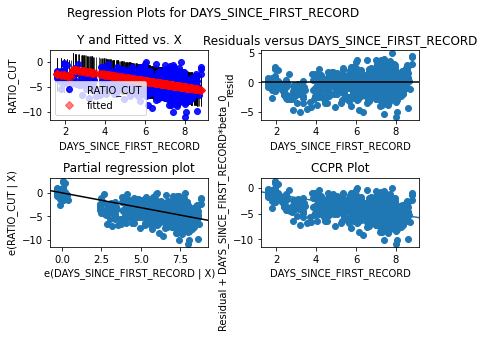

In [1418]:
fig =  smapi.graphics.plot_regress_exog(cut_model, "DAYS_SINCE_FIRST_RECORD")
fig.tight_layout(pad=1.0)

The residuals look reasonably normal

## 4. Describing the record risk function, by time

Unfortunately, we cannot repeat the above process to fit a distribution for DAYS_STANDING. The problem is that the dataset is biased: all of the standing records are cut off, and we don't know how long they will continue to stand.

The solution to this dilemma is to apply survival analysis. Survival analysis is a branch of statistics which deals with "censored" time-to-event data. One of its most-used methods is Kaplan Meier fitting, which estimates a distribution for how long it will take for an event to happen. We can apply it to our DAYS_STANDING column, using IS_STANDING to determine which records have not yet been broken

<AxesSubplot:xlabel='timeline'>

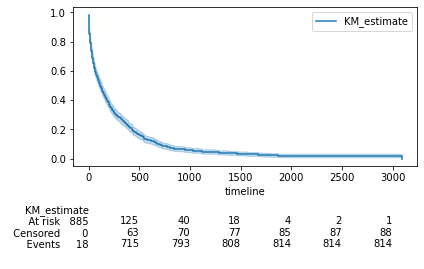

In [1419]:
kmf = KaplanMeierFitter()
kmf_fit = kmf.fit(records['DAYS_STANDING'],event_observed = ~records['IS_STANDING'])
kmf.plot(at_risk_counts=True)

That is the overall survival curve for records we have looked at. We can make some observations: e.g. after one year, about 10% of records are left standing

We can also break the analysis down by game

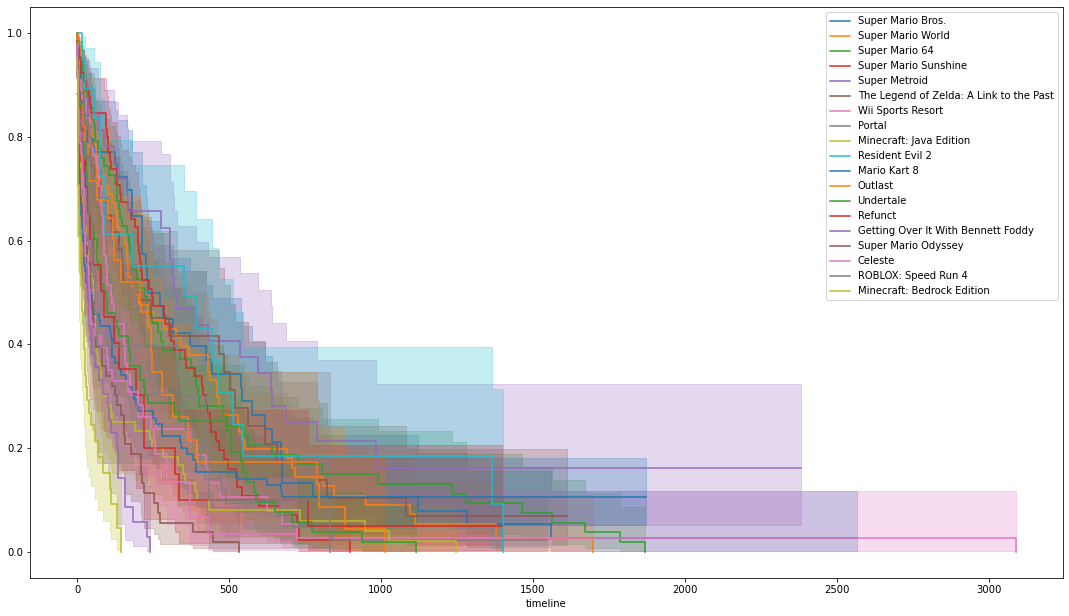

In [1420]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5, forward=True)

for game in records['GAME'].unique():
    
    flag = records['GAME'] == game
    
    kmf.fit(records['DAYS_STANDING'][flag]
            ,event_observed = ~records['IS_STANDING'][flag]
        , label=game)
    kmf.plot(ax=ax)

So according to our Kaplan-Meier estimate, Super Metroid records have the most staying power

We can also try parametric models, to see if any simple distributions can fit the data well. To see which parametric model is most applicable to this data, we look at QQ plots

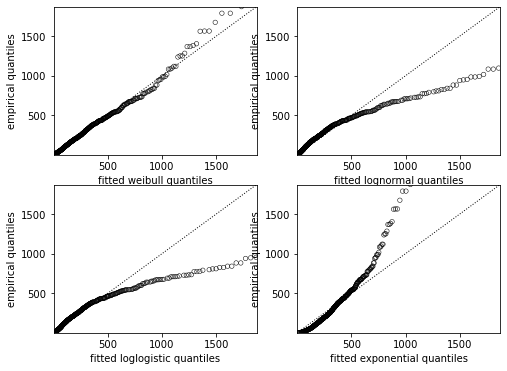

In [1421]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)

for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(records['DAYS_STANDING'] + 1,event_observed = ~records['IS_STANDING'])
    qq_plot(model, ax=axes[i])

Clearly Weibull is the most appropriate parametric model, even if there is some discrepancy at the tail

<AxesSubplot:>

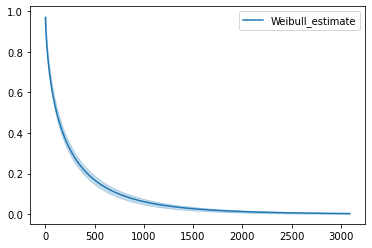

In [1422]:
from lifelines import WeibullFitter
from lifelines.plotting import qq_plot

wbf = WeibullFitter()
wbf_fit = wbf.fit(records['DAYS_STANDING'] + 1,event_observed = ~records['IS_STANDING'])
wbf.plot_survival_function()

We can also make break down the games separately with the Weibull distribution

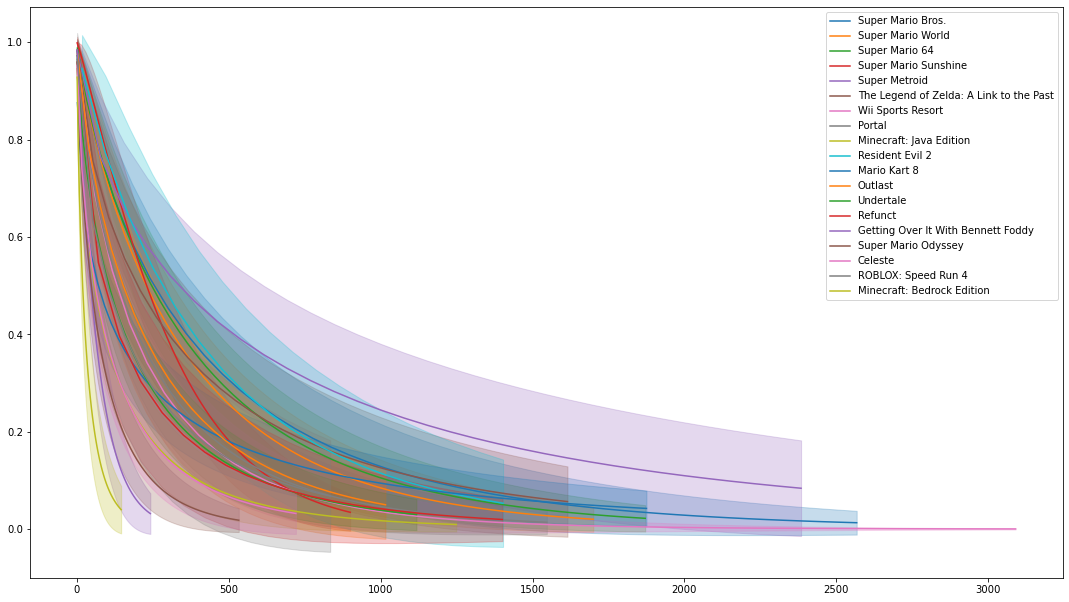

In [1423]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5, forward=True)

for game in records['GAME'].unique():
    
    flag = records['GAME'] == game
    
    wbf.fit(records['DAYS_STANDING'][flag] + 1
            ,event_observed = ~records['IS_STANDING'][flag]
        , label=game)
    wbf.plot_survival_function(ax=ax)


Again super metroid appears to have the most long-lasting records, in general 

One question we might ask: are larger record-breaks more or less likely to be broken quickly? We can approach that with a cox regression model, which is non-parametrics but allows external regressors

<lifelines.CoxPHFitter: fitted with 815 total observations, 88 right-censored observations>
             duration col = 'DAYS_STANDING'
                event col = 'NOT_STANDING'
      baseline estimation = breslow
   number of observations = 815
number of events observed = 727
   partial log-likelihood = -4105.51
         time fit was run = 2021-07-05 13:35:02 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                            
PREVIOUS_DAYS_STANDING_LOG                    -0.15       0.86       0.05            -0.24            -0.06                 0.78                 0.94
DAYS_SINCE_FIRST_RECORD_LOG                   -0.13       0.88       0.05            -0.23            -0.02                 0.79                 0.98
PREVIOUS_RUNS_STANDING_LOG                     0.22       1.24       0.08             0.07             0.37                 1.07                 1.44
CUMULATIVE_RUNS_LOG                           -0.11       0.89       0.08            -0.27             0.05                 0.76                 1.05
GAME_Getting Over It With Bennett Foddy        0.68       1.98       0.25             0.20             1.16                 1.23                 3.20
GAME_Mario Kart 8                             -0.33       0.72       0.21            -0.74             0.07                 0.48                 1.08
GAME_Minecraft: Bedrock Edition                0.78       2.19       0.24             0.31             1.26                 1.36                 3.53
GAME_Minecraft: Java Edition                   0.48       1.61       0.22             0.04             0.91                 1.05                 2.48
GAME_Outlast                                  -0.30       0.74       0.27            -0.83             0.23                 0.43                 1.26
GAME_Portal                                   -0.09       0.91       0.24            -0.56             0.37                 0.57                 1.45
GAME_ROBLOX: Speed Run 4                      -0.48       0.62       0.35            -1.17             0.20                 0.31                 1.23
GAME_Refunct                                   0.08       1.09       0.31            -0.53             0.69                 0.59                 2.00
GAME_Resident Evil 2                          -0.61       0.54       0.33            -1.25             0.04                 0.29                 1.04
GAME_Super Mario 64                           -0.34       0.71       0.23            -0.79             0.10                 0.45                 1.11
GAME_Super Mario Bros.                        -0.52       0.59       0.24            -0.99            -0.04                 0.37                 0.96
GAME_Super Mario Odyssey                       0.39       1.48       0.22            -0.03             0.82                 0.97                 2.27
GAME_Super Mario Sunshine                     -0.17       0.84       0.22            -0.60             0.25                 0.55                 1.29
GAME_Super Mario World                        -0.34       0.71       0.22            -0.78             0.09                 0.46                 1.10
GAME_Super Metroid                            -0.91       0.40       0.28            -1.46            -0.35                 0.23                 0.70
GAME_The Legend of Zelda: A Link to the Past  -0.57       0.57       0.27            -1.10            -0.04                 0.33                 0.96
GAME_Undertale                                -0.12       0.88       0.21            -0.54             0.30                 0.58                 1.35
GAME_Wii Sports Resort                        -0.06       0.94       0.23            -0.51             0.39                 0.60                 1.48

                          

<AxesSubplot:xlabel='log(HR) (95% CI)'>

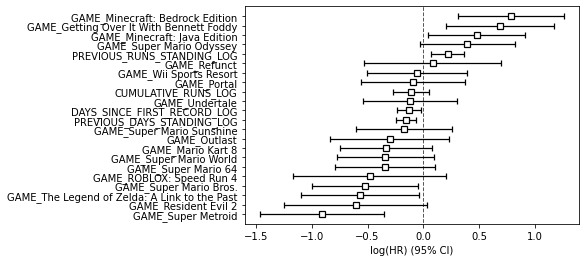

In [1424]:

def fit_time_cox(records):
    '''Does some data engineering, and fits survival model
    
    Args:
       records (df): data to train on

    Returns:
        Survival model, feature list, engineered records
    '''
    subsequent_records = records[records['RATIO_CUT'] == records['RATIO_CUT']].copy()
    subsequent_records.loc[:,'NOT_STANDING'] = ~subsequent_records['IS_STANDING']
    games = subsequent_records['GAME']
    subsequent_records = pd.get_dummies(subsequent_records, columns = ['GAME'], drop_first = True)
    subsequent_records.loc[:,'GAME'] = games

    subsequent_records.loc[:,'PREVIOUS_DAYS_STANDING_LOG'] = np.log(subsequent_records['PREVIOUS_DAYS_STANDING'] + 1)
    subsequent_records.loc[:,'DAYS_SINCE_FIRST_RECORD_LOG'] = np.log(subsequent_records['DAYS_SINCE_FIRST_RECORD'] + 1)
    
    subsequent_records.loc[:,'PREVIOUS_RUNS_STANDING_LOG'] = np.log(subsequent_records['PREVIOUS_RUNS_STANDING'] + 1)
    subsequent_records.loc[:,'CUMULATIVE_RUNS_LOG'] = np.log(subsequent_records['CUMULATIVE_RUNS'] + 1)

    features = ['PREVIOUS_DAYS_STANDING_LOG','DAYS_SINCE_FIRST_RECORD_LOG','PREVIOUS_RUNS_STANDING_LOG','CUMULATIVE_RUNS_LOG'] + \
                [col for col in subsequent_records.columns if (re.match('GAME_', col))]

    cph = CoxPHFitter()
    cph.fit(subsequent_records[['DAYS_STANDING','NOT_STANDING'] + features]
                ,duration_col = 'DAYS_STANDING'
                ,event_col = 'NOT_STANDING')
    return cph, features, subsequent_records

cph, cox_features, subsequent_records = fit_time_cox(records)
cph.print_summary()
cph.plot()

The concordance score of 0.65 is reasonably good. You can read more about concordance score [here](https://medium.com/analytics-vidhya/concordance-index-72298c11eac7#:~:text=The%20concordance%20index%20or%20c,number%20of%20possible%20evaluation%20pairs.&text=In%20that%20case%2C%20the%20concordance,to%20its%20maximum%20value%201.)

Some notes based on the summary:
- PREVIOUS_DAYS_STANDING appears to be have a significant (though slight) damping effect on risk: that is, when records are being broken quickly, they are likely to continue being broken
- DAYS_SINCE_FIRST_RECORD has an even more significant effect, suggesting that records stick around longer in older categories
- It seems like if anything, the higher RATIO_CUT records are more likely to stick around (their hazards are smaller). However, this effect is not quite significant, with a p-value of 0.06

## 5. Describing risk in terms of runs

Another option we have is to ignore time altogether, and think of runs as the operative time-like characteristic

<AxesSubplot:xlabel='timeline'>

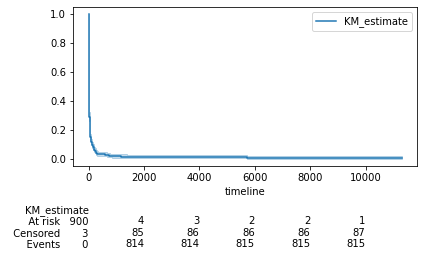

In [1425]:
kmf = KaplanMeierFitter()
kmf_fit = kmf.fit(records['RUNS_STANDING'],event_observed = ~records['IS_STANDING'])
kmf.plot(at_risk_counts=True)

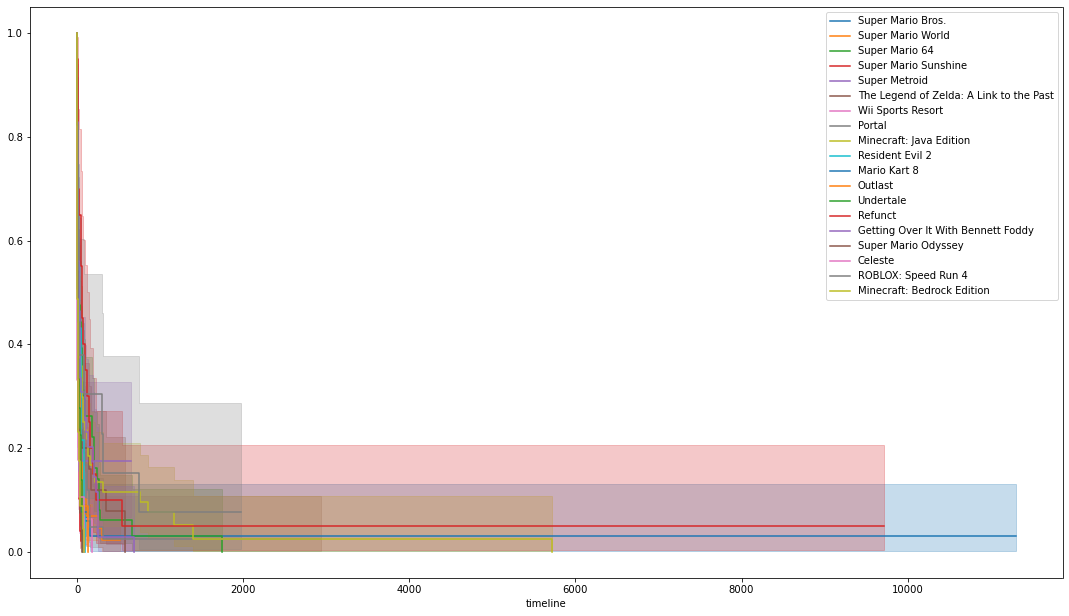

In [1426]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5, forward=True)

for game in records['GAME'].unique():
    
    flag = records['GAME'] == game
    
    kmf.fit(records['RUNS_STANDING'][flag]
            ,event_observed = ~records['IS_STANDING'][flag]
        , label=game)
    kmf.plot(ax=ax)

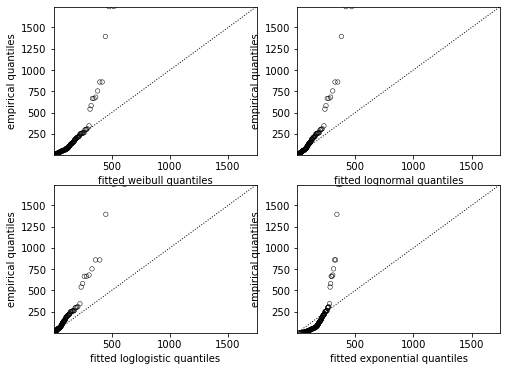

In [1427]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)

for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(records['RUNS_STANDING'] + 1,event_observed = ~records['IS_STANDING'])
    qq_plot(model, ax=axes[i])

<AxesSubplot:>

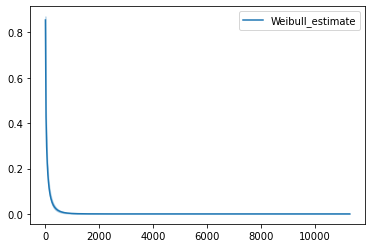

In [1428]:
wbf = WeibullFitter()
wbf_fit = wbf.fit(records['RUNS_STANDING'] + 1,event_observed = ~records['IS_STANDING'])
wbf.plot_survival_function()

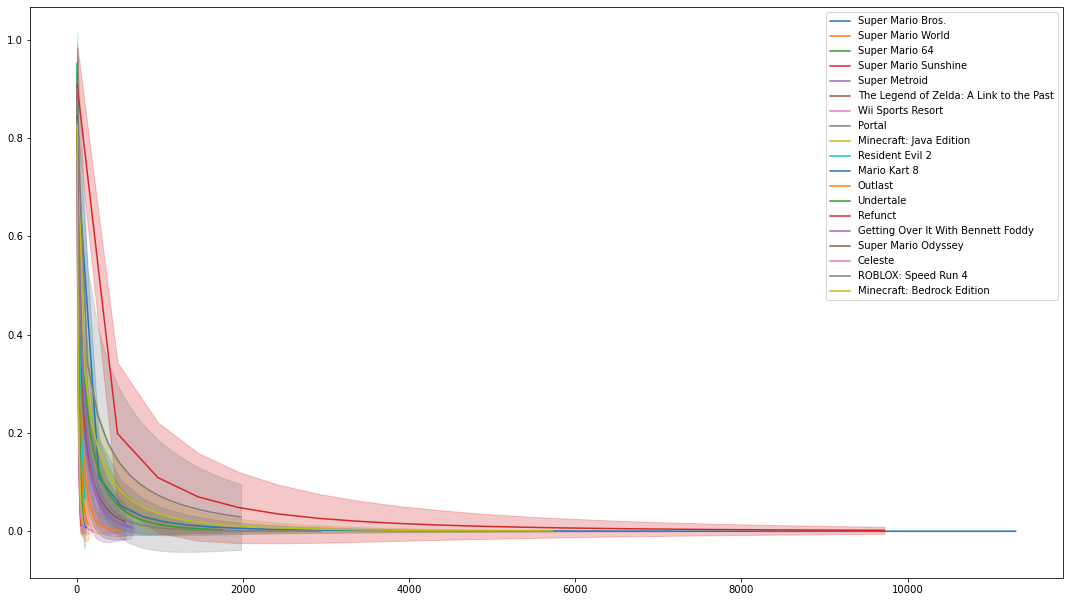

In [1429]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5, forward=True)

for game in records['GAME'].unique():
    
    flag = records['GAME'] == game
    
    wbf.fit(records['RUNS_STANDING'][flag] + 1
            ,event_observed = ~records['IS_STANDING'][flag]
        , label=game)
    wbf.plot_survival_function(ax=ax)


<lifelines.CoxPHFitter: fitted with 815 total observations, 88 right-censored observations>
             duration col = 'RUNS_STANDING'
                event col = 'NOT_STANDING'
      baseline estimation = breslow
   number of observations = 815
number of events observed = 727
   partial log-likelihood = -3998.25
         time fit was run = 2021-07-05 13:35:09 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                            
PREVIOUS_DAYS_STANDING_LOG                     0.11       1.11       0.05             0.02             0.20                 1.02                 1.22
DAYS_SINCE_FIRST_RECORD_LOG                   -0.12       0.88       0.06            -0.23            -0.02                 0.79                 0.98
PREVIOUS_RUNS_STANDING_LOG                    -0.21       0.81       0.08            -0.36            -0.06                 0.70                 0.94
CUMULATIVE_RUNS_LOG                           -0.31       0.73       0.08            -0.47            -0.15                 0.62                 0.86
GAME_Getting Over It With Bennett Foddy        0.25       1.29       0.24            -0.23             0.73                 0.80                 2.08
GAME_Mario Kart 8                             -0.08       0.92       0.21            -0.48             0.32                 0.62                 1.38
GAME_Minecraft: Bedrock Edition                0.09       1.10       0.24            -0.38             0.57                 0.68                 1.76
GAME_Minecraft: Java Edition                   0.17       1.18       0.23            -0.27             0.61                 0.76                 1.84
GAME_Outlast                                  -0.31       0.74       0.27            -0.84             0.23                 0.43                 1.25
GAME_Portal                                   -0.37       0.69       0.24            -0.84             0.10                 0.43                 1.11
GAME_ROBLOX: Speed Run 4                      -1.03       0.36       0.35            -1.72            -0.34                 0.18                 0.71
GAME_Refunct                                  -0.05       0.96       0.31            -0.65             0.56                 0.52                 1.75
GAME_Resident Evil 2                          -0.54       0.58       0.33            -1.18             0.10                 0.31                 1.10
GAME_Super Mario 64                           -0.29       0.75       0.23            -0.74             0.16                 0.48                 1.18
GAME_Super Mario Bros.                        -0.49       0.61       0.25            -0.99            -0.00                 0.37                 1.00
GAME_Super Mario Odyssey                       0.13       1.14       0.22            -0.29             0.56                 0.75                 1.74
GAME_Super Mario Sunshine                      0.01       1.01       0.22            -0.43             0.44                 0.65                 1.56
GAME_Super Mario World                        -0.44       0.65       0.22            -0.87            -0.00                 0.42                 1.00
GAME_Super Metroid                            -0.94       0.39       0.28            -1.49            -0.38                 0.22                 0.68
GAME_The Legend of Zelda: A Link to the Past  -0.66       0.52       0.27            -1.19            -0.13                 0.31                 0.88
GAME_Undertale                                -0.12       0.89       0.21            -0.54             0.30                 0.59                 1.35
GAME_Wii Sports Resort                        -0.14       0.87       0.23            -0.59             0.31                 0.55                 1.36

                          

<AxesSubplot:xlabel='log(HR) (95% CI)'>

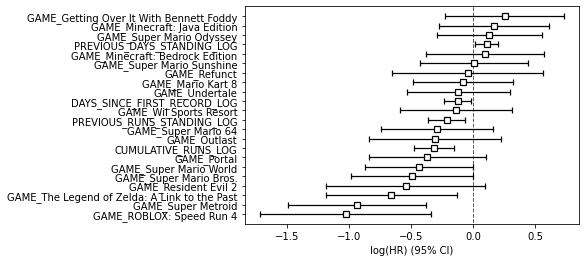

In [1430]:
cph_2 = CoxPHFitter()
cph_2.fit(subsequent_records[['RUNS_STANDING','NOT_STANDING'] + cox_features]
            ,duration_col = 'RUNS_STANDING'
            ,event_col = 'NOT_STANDING')
cph_2.print_summary()
cph_2.plot()

The survival model for runs is even better than the days version! That is good to know, but unfortunately it is hard to predict how many runs will happen in the future, so this does not help us make a concrete prediction. 

## 6. Putting it all together to predict future of records

Neither the RATIO_CUT distribution nor the survival model tells us how records will evolve in the future. They each give us only one piece of the puzzle

We have two ways to predict the evolution of records over time. One is to use a traditional time-series analysis, which we will try first. The other is to use out RATIO_CUT distribution and our survival model in tandem

### A. Time series model

In [1502]:
def get_time_series_df(records):
    '''Formats a record dataframe for time series analysis
    
    Args:
        records (df): data to transform

    Returns:
        records in long df format, which data for every day
    '''

    time_series_df = records[['DATE','TIME','CATEGORY','GAME']].copy()
    time_series_df['DATE'] = pd.to_datetime(time_series_df['DATE'])

    current_records = time_series = time_series_df.groupby(['GAME','CATEGORY'])[['TIME']].min()
    current_records.loc[:,'DATE'] = pd.to_datetime(datetime.datetime.today().date())

    time_series_df = pd.concat([time_series_df, current_records.reset_index()])

    time_series = time_series_df.groupby(['GAME','CATEGORY']).apply(lambda x : x.drop_duplicates('DATE')
                                                                      .set_index('DATE')['TIME']
                                                                      .resample('1D')
                                                                      .ffill())
    return time_series

def autoreg_wrapper(series, days_out):
    '''Performs autoregression and returns predictions
    
    Args:
        series (series): series to perform autoreg on (grouped by game and category)
        days_out (int): number of days out to make predictions for

    Returns:
        Predictions of records by game/category
    '''
    predictions = {}
    
    grouped_series = series.groupby(['GAME','CATEGORY'])
    for name, group in grouped_series:
        group.index = group.index.droplevel(0).droplevel(0)
        
        model = AutoReg(group, 5, trend = 'n')
        # fit model
        model_fit = model.fit()
        
        # make prediction
        forecast = model_fit.forecast(days_out)[days_out-1]

        predictions[name] = max(0,forecast) #we know time can't go negative
        
    return predictions

In [1503]:
time_series = get_time_series_df(records)
time_series_predictions = autoreg_wrapper(time_series, 1000)

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zac

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zac

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain

Autoregression is a simple time series method, which predicts future values by a weighted combination of previous values. Of course most of the time the future value will just be equal to the previous values, but the autoregressive model can understand that the record does drop sometimes and adjust its expectation to somewhere in the middle

### B. Simulation with survival model

Our other option is to use simulation to combine
- our temporal survival model
- the distribution function we created earlier for RATIO_CUT

Note that both the survival model and the RATIO_CUT model will be affected by the exact day that a record is broken. For efficiency reasons, we don't want to generate samples from distributions one by one for each simulation. So we will use a heuristic, and freeze the metrics in place currently

In [1504]:
def get_simulation_predictions(subsequent_records
                               , cph
                               , cox_features
                               , days_out
                               , pdf = None):
    
    '''Performs the simulation method to make predictions
    
    Args:
        subsequent_records (df): records data with initial records filtered out (we can't use them)
        cph: cox model
        cox_features (list): list of features used by cox model
        days_out (int): number of days out to make predictions for
        pdf (series): optional series to use for RATIO_CUT simulation. Alternative to linear model

    Returns:
        predictions by game/category
    '''
    
    standing_records = subsequent_records[subsequent_records['IS_STANDING']]
    standing_records = standing_records.set_index(['GAME','CATEGORY'])
    
    survival_table = cph.predict_survival_function(standing_records[cox_features]
                                 ,times=range(0,days_out))
    
    survival_table.columns = standing_records.index

    #the standing records have a different distribution, since they are conditional upon standing up to now
    survival_table_standing = cph.predict_survival_function(standing_records[cox_features]
                                 ,times=range(0,days_out)
                                 , conditional_after = standing_records['DAYS_STANDING'])

    survival_table_standing.columns = standing_records.index

    #we will set the possibility of no record being broken in the time frame to the 99999 index
    survival_table_pdf = (survival_table.shift(1).fillna(1) - survival_table)
    survival_table_pdf.loc[99999, : ] = survival_table.loc[days_out-1,:]
    
    survival_table_standing_pdf = (survival_table_standing.shift(1).fillna(1) - survival_table_standing)[1:]
    survival_table_standing_pdf.loc[99999, : ] = survival_table_standing.loc[days_out -1,:]
    
    probability_broken = 1 - survival_table_standing_pdf.loc[99999, : ]
    
    if pdf is None:
        cut_model = train_cut_model(subsequent_records)
        #by the time the record is broken, it will have stood at least for DAYS_SINCE_FIRST_RECORD and DAYS_STANDING
        standing_records['DAYS_SINCE_FIRST_RECORD'] += standing_records['DAYS_STANDING'] 
        log_predictions, sd = get_cut_distributions(standing_records, cut_model)
    
    res = {}
    for col in survival_table.columns:
        start_draw = list(rng.choice(a = np.array(survival_table_standing_pdf.index), size = days_out, p = survival_table_standing_pdf[col]))
        additional_draws = list(rng.choice(a = np.array(survival_table_pdf.index), size = days_out*100, p = survival_table_pdf[col]))
        
        if pdf is None:
            log_prediction = log_predictions.loc[col]
            #unwinding the distribution draws, which we got in the formal of a log estimate and standard deviation
            percent_off_draws = list(np.exp(np.random.normal(size = days_out*100)*sd + log_prediction))
        else: 
            percent_off_draws = list(rng.choice(a = pdf.index, size = days_out*100, p = pdf.values/sum(pdf.values))) 

        i_res = []
        for draw in start_draw:
            fraction = 1
            while draw < days_out:
                draw += additional_draws.pop()
                fraction *= (1-percent_off_draws.pop())
            i_res.append([fraction])
            
        res[col] = np.mean(i_res)*standing_records.loc[col,'TIME']
        
    return res, probability_broken

simulation_predictions, probability_broken = get_simulation_predictions(subsequent_records, cph, cox_features, 500)
print(list(simulation_predictions.keys())[0],list(simulation_predictions.values())[0])

('Celeste', '100%') 5700.242664925057


### C. Testing

Okay, interesting but... are these predictions accurate? Fortunately we don't have to rely entirely on speculation. We can run back the clock and test how the procedure would have performed based on information from many days ago. 

We should also see how well the models do compared to a naive way of predicting future records, holding them constant into the future. While this method is simple it has a strong mathematical advantage: for every record which is not broken, it will make a 100% accurate forecast

In [1505]:
def do_test(df
            , days_out
            , use_pdf = False):
    '''Performs backtesting
    
    Args:
        df (df): dataframe of games data
        days_out (int): number of days out to make predictions for
        use_pdf (boolean): controls whether we use the pdf method for RATIO_CUT simulation

    Returns:
        Dataframe of predictions by naive/simulation/time series
    '''
    date = datetime.datetime.today() - pd.DateOffset(days = days_out)

    actual_records = df.groupby(['GAME','CATEGORY'])['TIME'].min()

    df = df[pd.to_datetime(df['DATE']) <= date]

    records = feature_engineering(df)

    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(records['RATIO_CUT'].dropna(), bins = 100)
    best_dist = getattr(st, best_fit_name)

    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params) if use_pdf else None
    
    cph, cox_features, subsequent_records = fit_time_cox(records)
    simulation_predictions, probability_broken = get_simulation_predictions(subsequent_records
                                                                           ,cph
                                                                           ,cox_features
                                                                           ,days_out
                                                                           ,pdf
                                                                           )

    time_series = get_time_series_df(records)
    time_series_predictions = autoreg_wrapper(time_series, days_out)
    
    standing_records = records[records['IS_STANDING']].set_index(['GAME','CATEGORY'])['TIME']

    results = pd.merge(actual_records
                       , standing_records
                       , left_index = True
                       , right_index = True
                       , suffixes = ['_ACTUAL','_ORIGINAL'])
    
    results.loc[:,'SIM_PREDICTION'] = results.index.map(simulation_predictions)
    results.loc[:,'TS_PREDICTION'] = results.index.map(time_series_predictions)

    results.loc[:,'WAS_BROKEN'] = results['TIME_ACTUAL'] < results['TIME_ORIGINAL']
    results.loc[:,'SIM_PROBABILITY_BROKEN'] = results.index.map(probability_broken)

    return results


In [1506]:
results = do_test(full_df, 500)
y_cols = ['TIME_ORIGINAL','SIM_PREDICTION','TS_PREDICTION']
mapes = np.round([mean_absolute_percentage_error(results['TIME_ACTUAL'],results[y_col])*100 for y_col in y_cols],2)
r2s = np.round([r2_score(results['TIME_ACTUAL'],results[y_col])*100 for y_col in y_cols],2)

summary = pd.DataFrame({'MAPE' : mapes,'r2' : r2s}, index = y_cols)

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

In [1507]:
print(summary)

                 MAPE     r2
TIME_ORIGINAL    6.19  99.61
SIM_PREDICTION   5.51  99.79
TS_PREDICTION   10.69  98.92


We see that the simulation method improves on the naive model for this test set. Interestingly, the time series method performed predictions were actually worse than the naive model. Why was that?

In [1508]:
results

TIME_ACTUAL  \
GAME                               CATEGORY                            
Celeste                            Any%                     1589.194   
Getting Over It With Bennett Foddy Glitchless                 62.922   
                                   Snake                     122.638   
Mario Kart 8                       32 Tracks                3773.000   
                                   32 Tracks (No Items)     3651.000   
...                                                              ...   
Undertale                          Neutral Glitchless       3747.000   
                                   TPE Glitchless           6278.000   
                                   True Pacifist            4935.000   
Wii Sports Resort                  All Sports                957.000   
                                   Golf                       85.000   

                                                         TIME_ORIGINAL  \
GAME                               CATEGORY                              
Celeste                            Any%                       1659.166   
Getting Over It With Bennett Foddy Glitchless                   78.048   
                                   Snake                       145.424   
Mario Kart 8                       32 Tracks                  3773.000   
                                   32 Tracks (No Items)       3651.000   
...                                                                ...   
Undertale                          Neutral Glitchless         3769.000   
                                   TPE Glitchless             6338.000   
                                   True Pacifist              5078.000   
Wii Sports Resort                  All Sports                 1007.000   
                                   Golf                         86.000   

                                                         SIM_PREDICTION  \
GAME                               CATEGORY                               
Celeste                            Any%                     1569.804817   
Getting Over It With Bennett Foddy Glitchless                 76.367456   
                                   Snake                     140.846086   
Mario Kart 8                       32 Tracks                3768.331831   
                                   32 Tracks (No Items)     3651.000000   
...                                                                 ...   
Undertale                          Neutral Glitchless       3736.391316   
                                   TPE Glitchless           6284.116151   
                                   True Pacifist            5053.260247   
Wii Sports Resort                  All Sports               1004.530360   
                                   Golf                       85.473658   

                                                         TS_PREDICTION  \
GAME                               CATEGORY                              
Celeste                            Any%                     948.184862   
Getting Over It With Bennett Foddy Glitchless                 1.002567   
                                   Snake                     99.638453   
Mario Kart 8                       32 Tracks               3474.300767   
                                   32 Tracks (No Items)    3398.435206   
...                                                                ...   
Undertale                          Neutral Glitchless      3666.107462   
                                   TPE Glitchless          6152.680464   
                                   True Pacifist           4635.085277   
Wii Sports Resort                  All Sports               947.414950   
                                   Golf                      74.686439   

                                                         WAS_BROKEN  \
GAME                               CATEGORY                           
Celeste                            Any%                        True   
Getti

We can see that the time series model was far too optimistic about records going down. It did not predict that progress would slow over time, like the simulation model did. In theory there might be Bayesian methods that can incorporate this particular kind of diminishing marginal returns, but it would require additional effort beyond the AutoReg package

Another aspect of the predictions was how records would be broken at all. Since that is a binary target variable, it can be analyzed with a ROC curve

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning:

Pass fpr=[0.         0.         0.         0.05263158 0.05263158 0.31578947
 0.31578947 0.36842105 0.36842105 0.42105263 0.42105263 0.47368421
 0.47368421 0.57894737 0.57894737 0.63157895 0.63157895 0.68421053
 0.68421053 0.73684211 0.73684211 0.78947368 1.        ], tpr=[0.         0.02222222 0.33333333 0.33333333 0.51111111 0.51111111
 0.53333333 0.53333333 0.55555556 0.55555556 0.71111111 0.71111111
 0.8        0.8        0.84444444 0.84444444 0.86666667 0.86666667
 0.93333333 0.93333333 0.95555556 0.95555556 1.        ], roc_auc=0.7263157894736842 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error



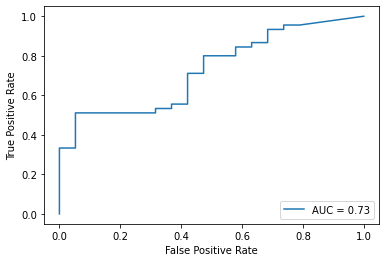

In [1509]:
fpr, tpr, t = roc_curve(results['WAS_BROKEN'], results['SIM_PROBABILITY_BROKEN'])
auc = roc_auc_score(results['WAS_BROKEN'], results['SIM_PROBABILITY_BROKEN'])
display = RocCurveDisplay(fpr, tpr, auc)
display.plot()
plt.show()

0.73 is not a terrible AUC

## Conclusion 

Our simulation procedure forecasted speedrunning records more accurately than the naive alternative we examined. This suggests that innovation in speedrunning can be predicted, at least to some degree. We also saw that the longer a record has been standing the less likely it is to be broken in the future, which lends credence to the intuitive hypothesis that innovation begets innovation

Of course this is only a first pass at forecasting speedrunning records, and there are many possible areas for improvement. In particular the time series approach could use fine-tuning to more accurately reflect the dyanmics of speedrunning
